# Linear Inverse Model

In [24]:
import nc_time_axis, cftime, functools
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as ctp
from importlib import reload

from hyblim.model import lim
from hyblim.data import preproc, eof 
from hyblim.utils import enso, metric, eval
import hyblim.geoplot as gpl

plt.style.use("../../paper.mplstyle")

# Parameters
config = dict(vars=['ssta', 'ssha'], n_eof = [20, 10],
              lim_type='cslim')
config['datapaths'] = {}
if 'ssta' in config['vars']:
    config['datapaths']['ssta'] = "../../data/cesm2-picontrol/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.ssta_lat-31_33_lon130_290_gr1.0.nc"
if 'ssha' in config['vars']:
    config['datapaths']['ssha'] = "../../data/cesm2-picontrol/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.ssha_lat-31_33_lon130_290_gr1.0.nc"
config['scorepath'] = "../../models/lim/cslim_ssta-ssha/metrics"
config['plotpath'] = "../../plots/lim/cslim_ssta-ssha/"

## Load data

In [2]:
da_arr, normalizer = [], {}
for var, path in config['datapaths'].items():
    da = xr.open_dataset(path)[var]
    # Normalize data 
    normalizer_var = preproc.Normalizer()
    da = normalizer_var.fit_transform(da)
    # Store normalizer as an attribute in the Dataarray for the inverse transformation
    da.attrs = normalizer_var.to_dict()
    da_arr.append(da)
    normalizer[var] = normalizer_var

ds = xr.merge(da_arr)

# Apply land sea mask
lsm = xr.open_dataset("../../data/land_sea_mask_common.nc")['lsm']
ds = ds.where(lsm!=1, other=np.nan)

In [3]:
# Create PCA
eofa_lst = []
for i, var in enumerate(ds.data_vars):
    print(f"Create EOF of {var}!")
    n_components = config['n_eof'][i] if isinstance(config['n_eof'], list) else config['n_eof'] 
    eofa = eof.EmpiricalOrthogonalFunctionAnalysis(n_components)
    eofa.fit(
        ds[var].isel(time=slice(None, int(0.8*len(ds['time']))))
    )
    eofa_lst.append(eofa)
combined_eof = eof.CombinedEOF(eofa_lst, vars=list(ds.data_vars))

Create EOF of ssta!
Create EOF of ssha!


In [4]:
# Split in training and test data
train_period = (0, int(0.8*len(ds['time'])))
val_period = (int(0.8*len(ds['time'])), int(0.9*len(ds['time'])))
test_period = ( int(0.9*len(ds['time'])), len(ds['time']) ) 

data = dict(
    train = combined_eof.transform(ds.isel(time=slice(*train_period))),
    val = combined_eof.transform(ds.isel(time=slice(*val_period))),
    test = combined_eof.transform(ds.isel(time=slice(*test_period))),
)

/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dat

## Create LIM

In [8]:
reload(lim)
if config['lim_type'] == 'stlim':
    model = lim.LIM(tau=1)
    print("Fit ST-LIM", flush=True)
    model.fit(data['train'].data)
    Q = model.noise_covariance()

elif config['lim_type'] == 'cslim':
    start_month = data['train'].time.dt.month[0].data
    model = lim.CSLIM(tau=1)
    print("Fit CS-LIM", flush=True)
    model.fit(data['train'].data.T, start_month, average_window=3)
    Q = model.noise_covariance()
else:
    raise ValueError("lim_type not recognized!")

Fit CS-LIM


## Hindcast mean

In [9]:
reload(preproc)
def hindcast_mean(model, da: xr.DataArray, lag: int) -> xr.DataArray:
    """Hindcast LIM mean for a given lag.

    Args:
        model (_type_): LIM model. 
        da (xr.DataArray): Input dataarray. 
        lag (int, optional): Lag time.

    Returns:
        xr.DataArray: Forecast dataarray
    """
    frcst_arr = []
    time_frcst = []
    for i, t in enumerate(da['time']):
        month = t.dt.month.data
        x_init = da.isel(time=i).data
        x_frcst = model.forecast_mean(x_init, month, lag)
        frcst_arr.append(x_frcst)

    # Use initial times
    da_frcst = xr.DataArray(data=frcst_arr, coords=dict(time=da['time'].data,
                                                       eof=da['eof'].data))
    da_frcst = da_frcst.assign_coords(coords=dict(lag=lag))
    return da_frcst

In [17]:
z_hindcast_arr, x_hindcast_arr = [], []
lag_arr = [1, 3, 6 ,9, 12, 15, 18, 21, 24]

for lag in lag_arr:
    print(f"Lag: {lag}")
    z = hindcast_mean(model, data['test'], lag=lag)
    # Transform hindcast to grid space
    x = eval.latent_frcst_to_grid(
        z.values[:,np.newaxis,:], data['test'].time, combined_eof, normalizer, extended_eof=None
    )
    z_hindcast_arr.append(z)
    x_hindcast_arr.append(x)
z_hindcast_mean = xr.concat(z_hindcast_arr, dim=pd.Index(lag_arr, name='lag'))
x_hindcast_mean = xr.concat(x_hindcast_arr, dim=pd.Index(lag_arr, name='lag'))

Lag: 1
Lag: 3
Lag: 6
Lag: 9
Lag: 12
Lag: 15
Lag: 18
Lag: 21
Lag: 24


## Optimal growth

In [19]:
lag_arr = np.arange(1, 25, 1)
month_arr = np.arange(1,13,1)

growth_rate, optimal_init_pc, optimal_evolved_pc = [], [], [] 
optimal_init_map, optimal_evolved_map = [], [] 
for i, month in enumerate(month_arr):
    growth = np.zeros(len(lag_arr))
    z_optimal_init, z_optimal_evolved = np.zeros((len(lag_arr), combined_eof.n_components)), np.zeros((len(lag_arr), combined_eof.n_components))
    for i, lag in enumerate(lag_arr):
        growth[i], z_optimal_init[i] = model.growth(month=month, lag=lag)
        z_optimal_evolved[i] = np.real(model.forecast_mean(z_optimal_init[i].T, month=month, lag=lag))

    growth_rate.append(xr.DataArray(data=growth, coords=dict(lag=lag_arr)))
    optimal_init_pc.append(xr.DataArray(data=z_optimal_init, coords=dict(lag=lag_arr, eof=np.arange(combined_eof.n_components))))
    optimal_evolved_pc.append(xr.DataArray(data=z_optimal_evolved, coords=dict(lag=lag_arr, eof=np.arange(combined_eof.n_components))))

    # Optimal initial codition to grid space
    x_opt_init = combined_eof.reconstruction(z_optimal_init, times=lag_arr)
    x_opt_init = x_opt_init.rename_dims({'time':'lag'})
    x_opt_evolved = combined_eof.reconstruction(z_optimal_evolved, times=lag_arr)
    x_opt_evolved = x_opt_evolved.rename_dims({'time':'lag'})
    optimal_init_map.append(x_opt_init)
    optimal_evolved_map.append(x_opt_evolved)

growth_rate = xr.concat(growth_rate, dim=pd.Index(month_arr, name='month'))
optimal_init_pc = xr.concat(optimal_init_pc, dim=pd.Index(month_arr, name='month'))
optimal_evolved_pc = xr.concat(optimal_evolved_pc, dim=pd.Index(month_arr, name='month'))
optimal_init_map = xr.concat(optimal_init_map, dim=pd.Index(month_arr, name='month'))
optimal_evolved_map = xr.concat(optimal_evolved_map, dim=pd.Index(month_arr, name='month'))

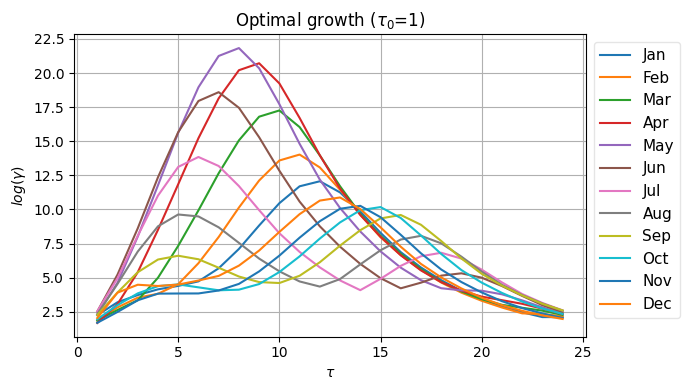

In [20]:
# Plot growth
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']
fig, ax = plt.subplots(figsize=(7,4))
for month in growth_rate['month'].data:
    growth_rate.sel(month=month).plot(ax=ax, label=month_label[month-1])

ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$log(\gamma)$")
ax.set_title(rf"Optimal growth ($\tau_0$={model.tau_0})")
ax.grid('y')
ax.legend(fontsize=11, bbox_to_anchor=(1,1), loc="upper left")

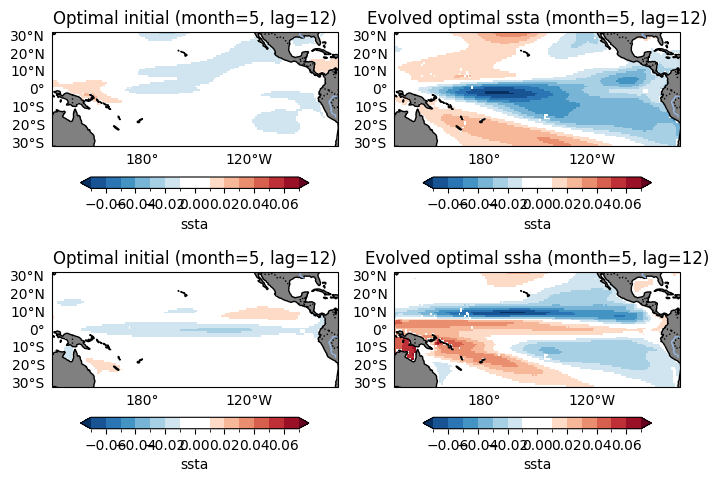

In [26]:
# Plot optimal initial and evolved patterns
reload(gpl)
init_month = 5
tau = 12
pltargs = {'ssta': dict(vmin=-0.07, vmax=0.07, eps=0.01, cmap='RdBu_r', centercolor='white'),
           'ssha': dict(vmin=-0.07, vmax=.07, eps=0.01, cmap='RdBu_r', centercolor='white')}

nrow, ncol = len(optimal_init_map.data_vars), 2
proj = ctp.crs.PlateCarree(central_longitude=180)
fig, axs = plt.subplots(nrow, ncol, figsize=(7, nrow*2.5), subplot_kw={'projection': proj})

for i, var in enumerate(optimal_init_map.data_vars):
    ax = axs[i,0]
    gpl.plot_map(optimal_init_map[var].sel(month=init_month, lag=tau), ax=ax, 
                 central_longitude=180, **pltargs[var])
    ax.set_title(f"Optimal initial (month={init_month}, lag={tau})")

    ax = axs[i,1]
    gpl.plot_map(optimal_evolved_map[var].sel(month=init_month, lag=tau), ax=ax, 
                 central_longitude=180, **pltargs[var])
    ax.set_title(f"Evolved optimal {var} (month={init_month}, lag={tau})")


In [25]:
# Save to file
optimal_init_map.to_netcdf(config['scorepath'] + "/optimal_init_map.nc")
optimal_evolved_map.to_netcdf(config['scorepath'] + "/optimal_evolved_map.nc")
optimal_init_pc.to_netcdf(config['scorepath'] + "/optimal_init_pc.nc")
optimal_evolved_pc.to_netcdf(config['scorepath'] + "/optimal_evolved_pc.nc")

### Project optimals on data (in pc-space) 

In [28]:
init_month = 12
tau = 12
dataset_key = 'test'

# Get init and target data
idx_val_init = np.where(data[dataset_key]['time.month'] == init_month)[0][:-1]
z_val_init = data[dataset_key].isel(time=idx_val_init)
z_val_target = data[dataset_key].isel(time=idx_val_init + tau)

# Get optimal initial and evolved patterns in PC space
opt_init = optimal_init_pc.sel(month=init_month, lag=tau)
opt_evolved = optimal_evolved_pc.sel(month=init_month, lag=tau)

proj_zdata_opt_init = opt_init.data @ z_val_init.data.T
proj_zdata_opt_evolved = opt_evolved.data @ z_val_target.data.T


In [30]:
# Get hindcast in PC-space
z_hat = model.forecast_mean(z_val_init.data.T, month=init_month, lag=tau)
proj_zfrcst_opt_evolved = opt_evolved.data @ z_hat

/dev/shm/_tmpdir_.ecm1922.30812711/ipykernel_4134545/1557966105.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Text(0.5, 0.98, 'Optimal initial (month=12, lag=12)')

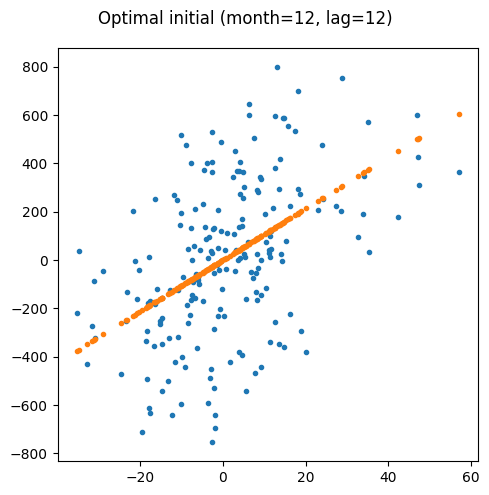

In [32]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(proj_zdata_opt_init, proj_zdata_opt_evolved, '.', label='Data')
ax.plot(proj_zdata_opt_init, proj_zfrcst_opt_evolved, '.', label='LIM forecast mean')
for ax in axs:
    ax.legend()
    ax.set_xlabel("Proj. on initial pattern")
    ax.set_ylabel("Proj. on evolved pattern")

plt.suptitle(f"Optimal initial (month={init_month}, lag={tau})")

## Expected skill

In [37]:
from tqdm import tqdm
def snr_square(model, da: xr.DataArray, lag: int) -> xr.DataArray:
    """Signal to noise ration over time squared for LIM.

    Args:
        model (CSLIM): CS-LIM model 
        da (xr.DataArray): 
        lag (int): _description_

    Returns:
        xr.DataArray: _description_
    """
    error_cov = np.zeros((12, len(da.eof), len(da.eof)))
    for init_month in np.arange(1, 13):
        target_month_idx = (init_month + lag -1) % 12 
        error_cov[target_month_idx] = model.error_covariance(init_month, lag)

    signal2noise_square = []
    for i, t in enumerate(da['time']):
        init_month = t.dt.month.data
        target_month_idx = (init_month + lag -1) % 12 

        # Hindcast
        z0 = da.isel(time=i).data
        z_frcst = model.forecast_mean(z0, init_month, lag)

        # Signal covariance f(tau, month, t) = x(tau, t) x(tau, t)^T
        signal_cov = z_frcst[:,np.newaxis] @ z_frcst[:, np.newaxis].T
        error_cov_month = error_cov[target_month_idx]

        signal2noise_square.append(np.trace(signal_cov) / np.trace(error_cov_month))

    target_time = da['time'].data[lag:]
    signal2noise_square = xr.DataArray(
        signal2noise_square[:-lag], 
        coords={'time': target_time}
    )
    return signal2noise_square


dataset_key = 'test'
da = data['test']
lag_arr = [1, 3, 6, 9, 12, 15, 18, 24]
snr_arr = []
for lag in tqdm(lag_arr):
    snr_arr.append(snr_square(model, da, lag))

snr_square = xr.concat(snr_arr, dim=pd.Index(lag_arr, name='lag'),
                       compat='equals', join='inner')

100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Text(0, 0.5, '$\\rho_\\infty$')

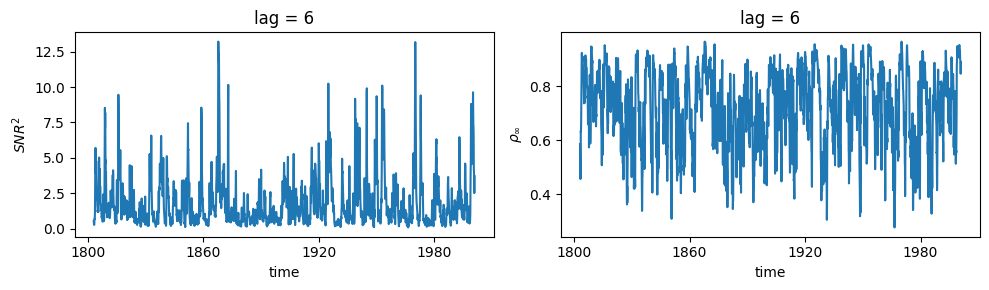

In [38]:
# Plot SNR^2 and theroretical correlation coefficient
lag = 6
correlation_coeff_theory = snr_square.sel(lag=lag) / np.sqrt( (1 + snr_square.sel(lag=lag)) *snr_square.sel(lag=lag) )

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
snr_square.sel(lag=lag).plot(ax=axs[0], label=r'$SNR^2$')
axs[0].set_ylabel(r'$SNR^2$')  
correlation_coeff_theory.plot(ax=axs[1], label=r'$\rho_\infty$')
axs[1].set_ylabel(r'$\rho_\infty$')

Text(0.5, 0, '$\\tau$')

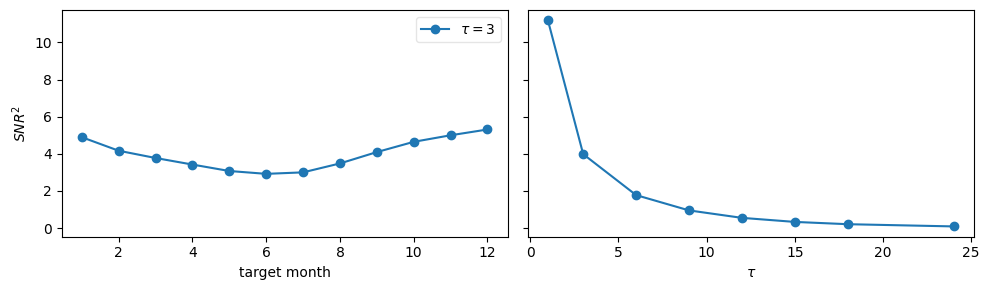

In [40]:
# Average SNR^2 over time for months and lad time
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
snr_month = snr_square.groupby('time.month').mean('time')
axs[0].plot(snr_month.month, snr_month.sel(lag=lag).data, 'o-', label=rf'$\tau={lag}$')
axs[0].set_xlabel("target month")
axs[0].set_ylabel(r"$SNR^2$")
axs[0].legend()
axs[1].plot(snr_square['lag'], snr_square.mean(dim='time'), 'o-')
axs[1].set_xlabel(r"$\tau$")

In [41]:
# Save SNR^2 to file
snr_square.to_dataset(name='snr2').to_netcdf(config['scorepath'] + f"/snr2_{dataset_key}_data.nc")

## Nyquist mode as function of number of EOFs

In [45]:
# PCA
reload(eof)
n_comp_arr = np.arange(2,25,2)
G_max = []
G_min = []
for n_components in n_comp_arr:
    print(f"Num of eofs: {n_components}")
    pca_lst = []
    for i, var in enumerate(ds.data_vars):
        print(f"Create EOF of {var}!")
        n_components = n_components // (2**i)
        eofa = eof.EmpiricalOrthogonalFunctionAnalysis(n_components=n_components)
        eofa.fit(ds[var])
        pca_lst.append(eofa)
    combined_eof = eof.CombinedEOF(pca_lst, vars=list(ds.data_vars))

    # Split in training and test data
    train_period = (0, int(0.8*len(ds['time'])))
    data_train = combined_eof.transform(ds.isel(time=slice(*train_period)))

    # Fit CSLIM
    cslim = lim.CSLIM(tau=1)
    start_month = data_train.time.dt.month[0].data
    cslim.fit(data_train.data.T, start_month, average_window=5)

    # Check for nyquist mode of G_T = G12 ... G1
    G_arr = []
    for i in range(cslim.G.shape[0]):
        idx = i % 12
        G_arr.append(cslim.G[idx])
    G_T = functools.reduce(np.dot, G_arr[::-1])

    # Check eigenvalues are between 0 and 1
    w, U, V = lim.matrix_decomposition(G_T)
    G_max.append(np.max(w))
    G_min.append(np.min(w)) 

Num of eofs: 2
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


Num of eofs: 4
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


Num of eofs: 6
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


Num of eofs: 8
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


Num of eofs: 10
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


Num of eofs: 12
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


Num of eofs: 14
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


Num of eofs: 16
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


Num of eofs: 18
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


Num of eofs: 20
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


Num of eofs: 22
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


Num of eofs: 24
Create EOF of ssta!
Create EOF of ssha!


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']


In [ ]:
fig, ax = plt.subplots()
G_min = np.array(G_min)
G_max = np.array(G_max)

ax.bar(n_comp_arr, height=G_max- G_min, bottom=G_min,
           label=r'[min($\lambda_{G}$), max($\lambda_{G}$)]')

ax.axhline(0, color='k')
#ax.axhline(1, color='k')
# ax.set_xticks(n_comp_arr)
# ax.set_ylim(-.1, .6)
ax.set_xlabel('# of EOF')
ax.set_ylabel(r"$\lambda_G$")
ax.legend()